In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import tensorflow as tf
import cv2
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
sys.path.append('../')
tf.random.set_seed(42)

from helpers import *
#from glash_v2 import glash_discriminator, glash_generator, Glash

2022-04-17 15:34:23.864361: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
def glash_discriminator(n=2, act_fun_1=tf.keras.activations.relu):
    """
    Discriminator network side of the GAN. It consists of a sequence of fully connected dense layers that output a
    probability of the input being real (1) or fake (0). It aims to distinguish between real and fake distributions
    (generation samples from the generative network).

    Arguments:
        - n: number of samples it takes as an input in 1D
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(n,)),
        tf.keras.layers.Dense(15, activation=act_fun_1,
                              kernel_initializer='he_uniform'),
        tf.keras.layers.Dense(10, activation=act_fun_1,
                              kernel_initializer='he_uniform'),
        #tf.keras.layers.Dense(50, activation=act_fun_1,
        #                     kernel_initializer='he_uniform'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ], name='glash_discriminator')

    return model
    

def glash_generator(latent_dim=5, act_fun_1=tf.keras.activations.relu, act_fun_2=tf.keras.activations.relu):
    """
    Generative network component of the GAN. It consists of a sequence of fully connected dense layers that output a
    newly generated distribution. It aims to generate a distribution that is close to the input distribution improving
    its weights and biases until the discriminator network is no longer able to recognise fake from real data.

    Arguments:
        - latent_dim: number of dimensions of the latent space
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(latent_dim,)),
        tf.keras.layers.Dense(15, activation=act_fun_1,
                              kernel_initializer='he_uniform'),
        tf.keras.layers.Dense(10, activation=act_fun_1,
                             kernel_initializer='he_uniform'),
        tf.keras.layers.Dense(2, activation=act_fun_2) # Test different activation functions for different shapes
    ], name='glash_generator')

    return model


class Glash(tf.keras.Model):

    def __init__(self, discriminator, generator, latent_dim=5):
        super(Glash, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, optimizerD, optimizerG, loss_fn, loss_fn_2):
        super(Glash, self).compile()
        self.optimizerD = optimizerD
        self.optimizerG = optimizerG
        self.loss_fn = loss_fn
        self.loss_fn_2 = loss_fn_2

    def train_step(self, real_data):
        if isinstance(real_data, tuple):
            real_data = real_data[0]

        # Generate fake data with the appropriate shape and batch size
        batch_size = tf.shape(real_data)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))
        fake_data = self.generator(noise)

        # Combine real and fake data for training the discriminator
        combined_data = tf.concat([real_data, fake_data], axis=0)
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

        # Training the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_data)
            d_loss = self.loss_fn(labels, predictions)

        # Update the weights of the discriminator
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.optimizerD.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Generate fake labels to train the generator
        misleading_labels = tf.ones((batch_size, 1))
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Training the generator
        with tf.GradientTape() as tape:
            fake_predictions = self.discriminator(self.generator(noise))
            g_loss = self.loss_fn_2(misleading_labels, fake_predictions)

        # Update the weights of the generator
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.optimizerG.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {'d_loss': d_loss, 'g_loss': g_loss, 'fake_pred': fake_predictions}
    
    def call(self, noise):
        return self.generator(noise)

In [3]:
mean = (1, 1)
cov = [[0.5, 0], [0, 0.5]] # Should be symmetric
x = np.random.multivariate_normal(mean, cov, 4000).astype('float32')

(array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
          1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,
          3.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,
          4.,  5.,  2.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  4.,  2.,  1.,
          4.,  5.,  1.,  2.,  1.,  1.,  2.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  1.,  0.,  0.,  4.,  5.,  3.,  7.,  3.,  3.,
         10.,  7.,  9.,  5.,  5.,  2.,  4.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  1.,  7.,  5., 10., 17.,
         12., 15., 16.,  7., 10.,  3.,  3.,  0.,  2.,  0.,  1.

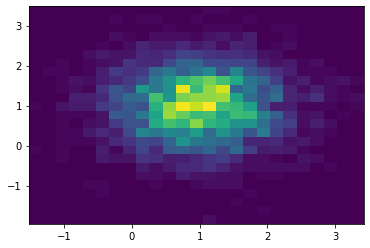

In [4]:
plt.hist2d(x[:, :1].reshape(4000,), x[:, 1:2].reshape(4000,), bins=25)

In [5]:
train_data = tf.data.Dataset.from_tensor_slices(x)
train_data = train_data.batch(32).prefetch(32)

2022-04-17 15:34:25.357868: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-17 15:34:25.360617: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-04-17 15:34:25.443179: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-17 15:34:25.443513: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.2GHz coreCount: 30 deviceMemorySize: 5.79GiB deviceMemoryBandwidth: 312.97GiB/s
2022-04-17 15:34:25.443564: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-04-17 15:34:25.446123: I tensorflow/stream_executor/platform/defa

In [6]:
glash = Glash(glash_discriminator(), glash_generator())
glash.compile(
    tf.keras.optimizers.Adam(),
    tf.keras.optimizers.Adam(),
    tf.keras.losses.BinaryCrossentropy(from_logits=True), # discriminator
    tf.keras.losses.BinaryCrossentropy(from_logits=True)
    #tf.keras.losses.mean_squared_error # generator
)

In [7]:
generated_point_list = []

cbk = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: show_samples(generated_point_list, epoch, glash.generator, x))

history = glash.fit(train_data, epochs=1000, callbacks=[cbk], verbose=False)

2022-04-17 15:34:26.540088: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-17 15:34:26.560320: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz
2022-04-17 15:34:26.657391: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


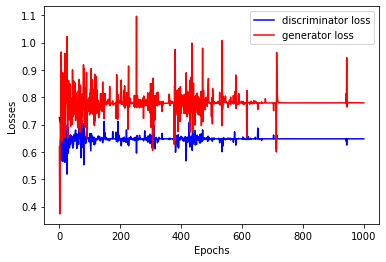

In [8]:
plt.plot(history.history['d_loss'], color='blue', label='discriminator loss')
line = plt.plot(history.history['g_loss'], color='red')
line[0].set_label("generator loss")

plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend()

In [9]:
noise = toy_data(4000, 0, 1).astype('float32')
noise.shape

(4000, 2)

In [10]:
np.random.uniform(0,1,(4000,5))

array([[0.90850245, 0.89085048, 0.39226937, 0.11528184, 0.58581947],
       [0.36154765, 0.86974602, 0.61867056, 0.88452091, 0.67351491],
       [0.61295679, 0.48668265, 0.28461306, 0.63396339, 0.81691398],
       ...,
       [0.05508195, 0.43413823, 0.33264023, 0.51005586, 0.40065885],
       [0.98484968, 0.04543734, 0.01486199, 0.96796996, 0.36923754],
       [0.57917298, 0.15985018, 0.59165934, 0.27012546, 0.84722295]])

(array([[ 0.,  0.,  0.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  2., 65.,  5.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 53., 38., 14.,  4.,  1.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 76., 56., 36., 17., 17.,  2.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 80., 52., 42., 29., 23.,  9.,  3.,  1.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., 15., 68., 56., 58., 40., 33., 29.,  7.,  2.,  1.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., 30., 53., 54., 64., 36., 47., 34., 14., 10.,  4.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

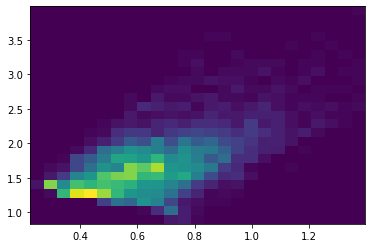

In [11]:
test = glash(np.random.uniform(0,1,(4000,5)))
x_test = tf.reshape(test[:, :1], (4000,))
y_test = tf.reshape(test[:, 1:2], (4000,))

plt.hist2d(x_test, y_test, bins=25)

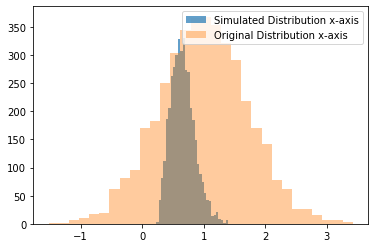

In [12]:
a = x_test.numpy()
plt.hist(a, alpha=0.7, bins=30, label="Simulated Distribution x-axis")
plt.hist(x[:, :1].reshape(4000,), alpha=0.4, bins=30, label="Original Distribution x-axis")
plt.legend()
#print(len(a), len(x[:, :1].reshape(4000,)))

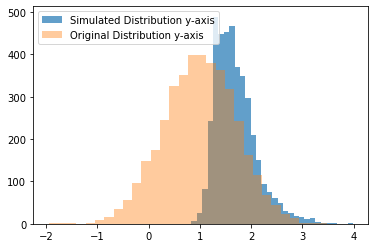

In [13]:
b = y_test.numpy()
plt.hist(b, alpha=0.7, bins=30, label="Simulated Distribution y-axis")
plt.hist(x[:, 1:2].reshape(4000,), alpha=0.4, bins=30, label="Original Distribution y-axis")
plt.legend()
#print(len(b), len(x[:, 1:2].reshape(4000,)))

(array([[ 0.,  0.,  0.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  2., 65.,  5.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 53., 38., 14.,  4.,  1.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 76., 56., 36., 17., 17.,  2.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 80., 52., 42., 29., 23.,  9.,  3.,  1.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., 15., 68., 56., 58., 40., 33., 29.,  7.,  2.,  1.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., 30., 53., 54., 64., 36., 47., 34., 14., 10.,  4.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

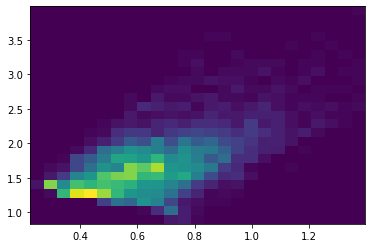

In [14]:
plt.hist2d(a, b, bins=25)

In [15]:
stats_gen_x = stats_dist(a, prnt=False)
stats_gen_y = stats_dist(b, prnt=False)

stats_or_x = stats_dist(x[:, :1].reshape(4000,), prnt=False)
stats_or_y = stats_dist(x[:, 1:2].reshape(4000,), prnt=False)

In [16]:
stats_df = df_generator(stats_or_x,
                        stats_gen_x,
                        stats_or_y,
                        stats_gen_y,
                        np.array(["Mean:", "Standard Deviation:",
                                  " Variance:", "Covariance:"]),
                        df_style)

stats_df

,,original_x_dim,generated_x_dim,original_y_dim,generated_y_dim
0,Mean:,0.989357,0.657238,0.997451,1.693854
1,Standard Deviation:,0.713135,0.196059,0.704198,0.400759
2,Variance:,0.508562,0.038439,0.495895,0.160608
3,Covariance:,0.508689,0.038449,0.496019,0.160648


In [17]:
# OpenCV function that compares 2 histograms, here specifically using the chi_square method to compute the distance
cv2.compareHist(x[:, :1].reshape(4000,), a, cv2.HISTCMP_CHISQR)

2280.5135550965542

506.16339535731396


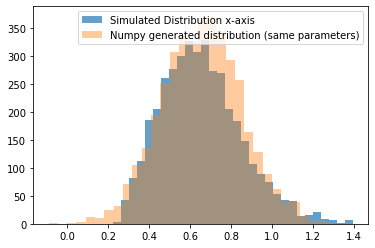

In [18]:
np_sample_1 = np.random.normal(stats_gen_x[0], stats_gen_x[1], 4000).astype("float32")

plt.hist(a, alpha=0.7, bins=30, label="Simulated Distribution x-axis")
plt.hist(np_sample_1, alpha=0.4, bins=30, label="Numpy generated distribution (same parameters)")
plt.legend()

print(cv2.compareHist(a, np_sample_1, cv2.HISTCMP_CHISQR))

759.9744004093067


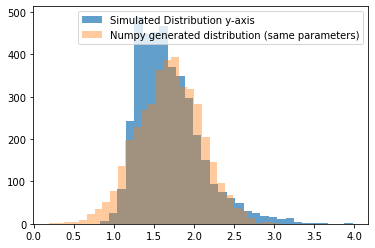

In [19]:
np_sample_2 = np.random.normal(stats_gen_y[0], stats_gen_y[1], 4000).astype("float32")

plt.hist(b, alpha=0.7, bins=30, label="Simulated Distribution y-axis")
plt.hist(np_sample_2, alpha=0.4, bins=30, label="Numpy generated distribution (same parameters)")
plt.legend()

print(cv2.compareHist(b, np_sample_2, cv2.HISTCMP_CHISQR))

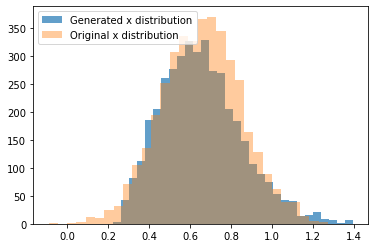

In [24]:
plot_ht = plt.hist(a, bins=30, alpha=0.7, label="Generated x distribution")
plot_ht_2 = plt.hist(np_sample_1, bins=30, alpha=0.4, label="Original x distribution")
plt.legend()

new_x = align_hist(plot_ht, plot_ht_2, 30)

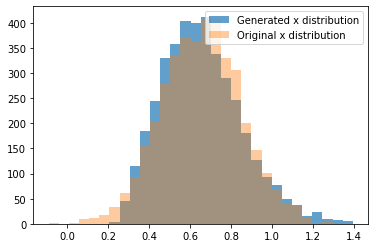

In [25]:
plot_ht = plt.hist(a, bins=new_x, alpha=0.7, label="Generated x distribution")
plot_ht_2 = plt.hist(np_sample_1, bins=new_x, alpha=0.4, label="Original x distribution")
plt.legend()

new_new_x = norm_hist(plot_ht[0], new_x)

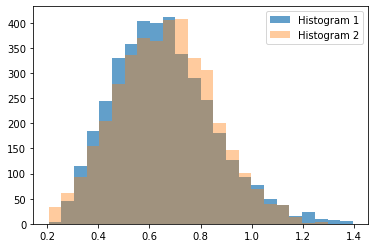

In [26]:
# Only possible with close enough histograms
plot_ht = plt.hist(a, bins=new_new_x, alpha=0.7, label="Histogram 1")
plot_ht_2 = plt.hist(np_sample_1, bins=new_new_x, alpha=0.4, label="Histogram 2")
plt.legend()

In [27]:
h1 = plot_ht[0]; h2 = plot_ht_2[0]

chi_squared(h1, h2)

415.232025339798